# Experiments in Modeling Issue Segmentation

### Load Libraries and Datasets

In [71]:
import os
import pandas as pd
from tqdm import tqdm
import altair as alt
alt.data_transformers.disable_max_rows()
from collections import deque
import warnings
warnings.filterwarnings('ignore')
from rich.console import Console

console = Console()
import sys

sys.path.append("..")
from segmentation_scripts.utils import read_csv_file

In [72]:
full_df = read_csv_file("../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038071/mdp_39015056038071_annotated_individual_tokens.csv")
console.print(f"Dataframe is this size: {len(full_df)}")
console.print(f"Dataframe has this many issues: {full_df.start_issue.nunique()}")

Dataframe is this size: 300791

Dataframe has this many issues: 26

### Clean and Visualize Page Numbers

In [87]:
def clean_digits(df):
    df['token'] = df['token'].astype(str)
    if 'volume_name' in df.columns:
        df['volume_number'] = df['volume_number'].fillna(0)
    
    subset_digits = df[df['token'].str.isdigit()].copy()
    subset_digits['number'] = subset_digits['token'].astype(int, errors='ignore')
    subset_digits['implied_zero'] = subset_digits['page_number'].astype(int) - subset_digits['number']
    
    return subset_digits

subset_digits = clean_digits(full_df)
console.print(f"After cleaning digits, we have this many rows: {len(subset_digits)}")
console.print(f"Which gives us this many potential digit candidates per issue: {subset_digits.start_issue.value_counts()}")

After cleaning digits, we have this many rows: 6885

Which gives us this many potential digit candidates per issue: start_issue
1962-05-14    320
1962-04-23    319
1962-04-02    307
1962-03-26    307
1962-03-19    307
1962-03-12    301
1962-04-16    296
1962-04-30    296
1962-01-08    289
1962-05-28    288
1962-06-25    285
1962-02-26    277
1962-05-21    273
1962-03-05    266
1962-02-12    263
1962-06-18    259
1962-05-07    251
1962-02-05    247
1962-01-22    231
1962-02-19    230
1962-06-11    222
1962-04-09    218
1962-06-04    215
1962-01-01    211
1962-01-15    208
1962-01-29    199
Name: count, dtype: int64

In [107]:
import pandas as pd
from collections import deque
from tqdm import tqdm

def detect_issue_boundaries(df, window_size=5, threshold_sizes=[30]):
    # Prepare the DataFrame by ensuring necessary columns are integers
    df['page_number'] = df['page_number'].astype(int)
    df['implied_zero'] = df['implied_zero'].astype(int)
    
    # Sort by page_number and aggregate by unique pages for sequential window analysis
    df = df.sort_values(by=['page_number', 'start_issue']).drop_duplicates(subset=['page_number']).reset_index(drop=True)
    
    # Initialize list to store detected boundaries across all thresholds
    all_boundaries = []
    
    for threshold in tqdm(threshold_sizes, desc="Threshold Sizes"):
        # Initialize deque to maintain a sliding window of page numbers
        sliding_window = deque(maxlen=window_size)
        
        # Initialize list to store detected boundaries for this threshold
        issue_boundaries = []
        issue_number = 0
        existing_start_issue = None
        page_seen = set()  # Keep track of pages that have already been processed
        
        for idx, row in df.iterrows():
            page = row['page_number']
            implied_zero = row['implied_zero']
            
            # Avoid processing the same page multiple times
            if page in page_seen:
                continue
            page_seen.add(page)
            
            if idx == 0:
                existing_start_issue = row['start_issue']
                
            # Add current page to the sliding window
            sliding_window.append((page, implied_zero))
            
            if len(sliding_window) == window_size:
                # Calculate the range (difference) of page numbers within the window
                page_range = max(p[0] for p in sliding_window) - min(p[0] for p in sliding_window)
                implied_zero_diff = max(p[1] for p in sliding_window) - min(p[1] for p in sliding_window)
                
                # If range exceeds threshold, we might have detected an issue boundary
                if page_range > threshold or implied_zero_diff > threshold:
                    issue_boundaries.append((page, implied_zero, 'potential_boundary', row['start_issue'], issue_number, threshold))
                    
                    # Only increment issue_number when a new start_issue is encountered and not the same as the existing one
                    if existing_start_issue != row['start_issue']:
                        issue_number += 1
                        existing_start_issue = row['start_issue']
        
        # Append results for this threshold to all boundaries
        all_boundaries.extend(issue_boundaries)
    
    # Create DataFrame for all boundaries with threshold as a column
    boundaries_df = pd.DataFrame(all_boundaries, columns=['page_number', 'implied_zero', 'status', 'start_issue', 'status_issue_number', 'threshold'])
    return boundaries_df

# Example usage with multiple threshold sizes
threshold_sizes = [10, 20, 30, 40, 50]
boundaries_df = detect_issue_boundaries(subset_digits, threshold_sizes=threshold_sizes)

# Display results
console.print(f"Detected this many potential boundaries: {len(boundaries_df)} across this many thresholds: {threshold_sizes}")
console.print("Detected potential boundaries per threshold:\n", boundaries_df.groupby(['threshold']).size())

Threshold Sizes: 100%|██████████| 5/5 [00:00<00:00, 37.00it/s]


Detected this many potential boundaries: 2947 across this many thresholds: [10, 20, 30, 40, 50]

Detected potential boundaries per threshold:
 threshold
10    747
20    599
30    541
40    533
50    527
dtype: int64

In [108]:
boundaries_df.groupby(['start_issue', 'status_issue_number']).size()

start_issue  status_issue_number
1962-01-01   0                      106
1962-01-08   0                        5
             1                      129
1962-01-15   1                        5
             2                      126
1962-01-22   2                        5
             3                      102
1962-01-29   3                        5
             4                       85
1962-02-05   4                        5
             5                      127
1962-02-12   5                        5
             6                       86
1962-02-19   6                        5
             7                      132
1962-02-26   7                        5
             8                      122
1962-03-05   8                        5
             9                      125
1962-03-12   9                        5
             10                      77
1962-03-19   10                       5
             11                     111
1962-03-26   11                       5
       

In [54]:
merged_boundaries_digits_df = pd.merge(subset_digits, boundaries_df, on=['page_number', 'implied_zero'], how='left')	

In [55]:
def get_predicted_page(df, range_of_max_issue_length, window_size=2):
    dfs = []
    
    for max_issue_length in tqdm(range_of_max_issue_length, desc="Predicting Page Number"):
        copied_df = df.copy()
        max_page = copied_df['page_number'].max()
        max_possible_number = max_page + max_issue_length
        
        filtered_df = copied_df[copied_df['number'] < max_possible_number]
        
        grouped_pages = filtered_df.groupby('implied_zero').size().reset_index(name='counts')
        grouped_pages = grouped_pages[grouped_pages['counts'] > max_issue_length - 5].reset_index(drop=True)
        
        # Pre-allocate columns with `None`
        copied_df = copied_df.assign(predicted_page=None, predicted_issue_number=None, max_issue_length=max_issue_length)
        for index, row in grouped_pages.iterrows():
            # Using vectorized operations to assign predictions
            zero_window = [max(0, row.implied_zero - window_size), row.implied_zero + window_size]
            zero_range = range(zero_window[0], zero_window[1] + 1)
            
            is_within_window = copied_df['page_number'].isin(zero_range)
            copied_df.loc[is_within_window, 'predicted_page'] = 'predicted_beginning_of_issue'
            copied_df.loc[is_within_window, 'predicted_issue_number'] = f"issue {index}"
        
        dfs.append(copied_df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

range_of_max_issue_length = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 300]
predicted_df = get_predicted_page(merged_boundaries_digits_df, range_of_max_issue_length)

Predicting Page Number: 100%|██████████| 16/16 [00:00<00:00, 31.77it/s]


In [68]:
predicted_df[predicted_df.status == "potential_boundary"][['start_issue', 'predicted_page', 'predicted_issue_number', 'status', 'max_issue_length', 'page_number']].drop_duplicates()

,start_issue,predicted_page,predicted_issue_number,status,max_issue_length,page_number
0,1962-04-16,predicted_beginning_of_issue,issue 230,potential_boundary,10,549
24,1962-04-16,predicted_beginning_of_issue,issue 230,potential_boundary,10,550
33,1962-04-16,predicted_beginning_of_issue,issue 231,potential_boundary,10,552
36,1962-04-16,predicted_beginning_of_issue,issue 232,potential_boundary,10,553
45,1962-04-16,predicted_beginning_of_issue,issue 232,potential_boundary,10,554


In [58]:
# def clean_digits(df):
#     df.token = df.token.astype(str)
#     if 'volume_name' in df.columns.tolist():
#         df.volume_number = df.volume_number.fillna(0)
#     subset_digits = df[(df.token.str.isdigit()) ]
#     subset_digits['number'] = subset_digits.token.astype(int)
#     subset_digits['implied_zero'] = subset_digits.page_number.astype(int) - subset_digits.number
#     return subset_digits

# subset_digits = clean_digits(full_df)

In [59]:
# def get_predicted_page(df, range_of_max_issue_length):
#     dfs = []
#     for max_issue_length in tqdm(range_of_max_issue_length, desc="Predicting Page Number"):
#         copied_df = df.copy()
#         max_page = copied_df.page_number.max()
#         max_possible_number = max_page + max_issue_length
#         filtered_df = copied_df[copied_df.number < max_possible_number]
#         grouped_pages = filtered_df.groupby('implied_zero').size().reset_index(name='counts')
#         grouped_pages = grouped_pages[grouped_pages.counts > max_issue_length - 5]
#         grouped_pages = grouped_pages.reset_index(drop=True)
#         copied_df['predicted_page'] = None
#         copied_df['predicted_issue_number'] = None
#         copied_df['max_issue_length'] = max_issue_length
        
#         for index, row in grouped_pages.iterrows():
#             zero_window = [row.implied_zero -2, row.implied_zero + 2]
#             zero_window = [max(0, x) for x in zero_window]
#             for count in range(zero_window[0], zero_window[1]):
#                 copied_df.loc[(copied_df.page_number == count), 'predicted_page'] = 'predicted_beginning_of_issue'
#                 copied_df.loc[(copied_df.page_number == count), 'predicted_issue_number'] = f"issue {index}"
#         dfs.append(copied_df)
#     combined_df = pd.concat(dfs)
#     return combined_df

# range_of_max_issue_length = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 300]

# predicted_df = get_predicted_page(subset_digits, range_of_max_issue_length)

In [7]:
### Annotated Datasets

def get_annotated_datasets(df, range_of_max_issue_length, rewrite_files):
       predictions_path = "../issue_segments/predicted_issue_segments_for_annotated_issues.csv"
       issues_path = "../derived_annotated_datasets/issue_segments_for_annotated_issues.csv"
       if (os.path.exists(predictions_path)) and (os.path.exists(issues_path)) and (rewrite_files == False):
              predictions = pd.read_csv(predictions_path)
              final_df = pd.read_csv(issues_path)
       else:
              subset_digits = clean_digits(df)
              tqdm.pandas()
              htids = subset_digits.htid.unique().tolist()
              dfs = []
              for htid in tqdm(htids, total=len(htids), desc='Processing digits'):
                     subset_df = subset_digits[subset_digits.htid == htid]
                     subset_df = get_predicted_page(subset_df, range_of_max_issue_length)
                     dfs.append(subset_df)
              combined_subset_digits = pd.concat(dfs)
              combined_subset_digits = combined_subset_digits.reset_index(drop=True)
              digit_cols = combined_subset_digits.columns.tolist()
              digit_cols = [x for x in digit_cols if x not in ['pos', 'count', 'section', 'token']]
              combined_subset_digits = combined_subset_digits[digit_cols]
              cols = list(set(df) & (set(combined_subset_digits)))
              

              merged_df = pd.merge(df, combined_subset_digits, on=cols, how='left')
              if merged_df['volume_number'].isna().all():
                     merged_df = merged_df.drop(columns='volume_number')
              cols = cols + ['predicted_page', 'predicted_issue_number', 'max_issue_length']
              subset_predictions = combined_subset_digits[cols].drop_duplicates()
              subset_predictions = subset_predictions[(subset_predictions.type_of_page == 'cover_page') & (subset_predictions.predicted_page.notna())]
              pages_cols = merged_df.columns.tolist()
              holdout_cols = ['section', 'token', 'pos', 'count', 'number', 'implied_zero']
              pages_cols = [x for x in pages_cols if x not in holdout_cols]
              pages_df = merged_df[pages_cols]
              pages_df = pages_df.drop_duplicates()
              groupby_cols = ['cleaned_magazine_title', 'ht_generated_title', 'volume_number', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence'] if 'volume_number' in merged_df.columns else ['cleaned_magazine_title', 'ht_generated_title', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence']
              final_df = merged_df.groupby(groupby_cols, as_index = False).agg({'token': ' '.join, 'count': list, 'number': list, 'implied_zero': list})
              final_cols = list(set(pages_df) & set(final_df))
              finalized_df = pd.merge(pages_df, final_df, on=final_cols, how='left')
              all_predictions = finalized_df[finalized_df.predicted_page.notna()]
              grouped_df = df.groupby(groupby_cols, as_index = False).agg({'token': ' '.join})
              pred_cols = list(set(grouped_df) & set(subset_predictions))

              pred_merged_df = pd.merge(grouped_df, subset_predictions, on=pred_cols, how='left')
              # predictions.to_csv(predictions_path, index=False)
              # finalized_df.to_csv(issues_path, index=False)
       return finalized_df, all_predictions, pred_merged_df

In [10]:
def get_annotations(large_files, initial_df, range_of_max_issue_length, rewrite_files):
    if large_files == True:
        # annotated_dfs = []
        all_predictions_dfs = []
        predictions_dfs = []
        for directory, subdir, files in os.walk("derived_files/temp/"):
            for file in tqdm(files, desc="Files"):
                # if file.startswith("issue_segments_for_annotated_issues"):
                #     annotated_df = pd.read_csv(f"{directory}/{file}")
                #     annotated_dfs.append(annotated_df)
                if (file.startswith("predicted_issue_segments_for_annotated_issues")) and ('merged' not in file):
                    all_predictions = pd.read_csv(f"{directory}/{file}")
                    all_predictions_dfs.append(all_predictions)
                elif file.startswith("predicted_issue_segments_for_annotated_issues_merged"):
                    predictions_df = pd.read_csv(f"{directory}/{file}")
                    predictions_dfs.append(predictions_df)
        # final_annotated_df = pd.concat(annotated_dfs)
        all_predictions = pd.concat(all_predictions_dfs)
        predictions_df = pd.concat(predictions_dfs)
        annotated_df = pd.DataFrame()
    else:
        annotated_df, all_predictions, predictions_df = get_annotated_datasets(initial_df, range_of_max_issue_length, rewrite_files=True)
        print(len(annotated_df[(annotated_df.type_of_page == 'cover_page') & (annotated_df.predicted_page.notna())]), len(annotated_df[(annotated_df.type_of_page == 'cover_page') & (annotated_df.predicted_page.isna())]))
        print(predictions_df[(predictions_df.predicted_page.notna()) & (predictions_df.token.str.len() < 200)][0:1].to_dict())
    return annotated_df, all_predictions, predictions_df

In [11]:
annotated_df, all_predictions, predictions_df = get_annotations(large_files=True, initial_df=initial_df, range_of_max_issue_length=range_of_max_issue_length, rewrite_files=True)

Files: 100%|██████████| 51/51 [00:28<00:00,  1.82it/s]


In [12]:
issue_count = all_predictions.groupby(['cleaned_magazine_title', 'htid', 'max_issue_length']).predicted_issue_number.nunique().reset_index()

alt.Chart(issue_count).mark_bar().encode(
    x=alt.X('sum(predicted_issue_number):Q'),
    y=alt.Y('cleaned_magazine_title:N', sort='-x'),
    row=alt.Row('max_issue_length:N'),
)

alt.Chart(...)

In [13]:
annotated_issue_count = initial_df.groupby(['cleaned_magazine_title', 'htid']).start_issue.nunique().reset_index()

alt.Chart(annotated_issue_count).mark_bar().encode(
    x=alt.X('sum(start_issue):Q'),
    y=alt.Y('cleaned_magazine_title:N', sort='-x')
)

alt.Chart(...)

In [14]:
combined_df = pd.merge(issue_count, annotated_issue_count, on=['cleaned_magazine_title', 'htid'], how='left')

melted_df = pd.melt(combined_df, id_vars=['cleaned_magazine_title', 'htid', 'max_issue_length'], value_vars=['predicted_issue_number', 'start_issue'])
melted_df.loc[melted_df.variable == 'predicted_issue_number', 'variable'] = 'Predicted Number of Issues'
melted_df.loc[melted_df.variable == 'start_issue', 'variable'] = 'Annotated Number of Issues'

In [15]:
alt.Chart(melted_df).mark_bar().encode(
    x=alt.X('sum(value):Q'),
    y=alt.Y('variable:N', sort='-x'),
    color=alt.Color('variable:N'),
    row=alt.Row('max_issue_length:N', header=alt.Header(labelAngle=0, labelAlign='left'), title=None,),
    column=alt.Column('cleaned_magazine_title:N', header=alt.Header(labelAngle=0, labelAlign='left'), title=None,),
)

alt.Chart(...)

### Experiment with Textual Features

In [16]:
import nltk
from nltk import word_tokenize, sent_tokenize

predictions_df['token'] = predictions_df.token.fillna('')
predictions_df['token'] = predictions_df.token.astype(str)
predictions_df['token_length'] = predictions_df.token.str.len()
predictions_df['tokenized_text'] = predictions_df.token.apply(word_tokenize)
predictions_df['tokenized_text_length'] = predictions_df.tokenized_text.str.len()
predictions_df['sentences'] = predictions_df.token.apply(sent_tokenize)
predictions_df['sentences_length'] = predictions_df.sentences.str.len()

In [17]:
sizes = predictions_df.groupby(['cleaned_magazine_title', 'datetime']).size().reset_index(name='issue_size')
sizes = sizes.sort_values(by=['datetime'])
# fully_cleaned_ao = fully_cleaned_ao.merge(sizes, on=['date'], how='outer')
counts = predictions_df.groupby(['cleaned_magazine_title', 'datetime'])['token_length'].sum().reset_index(name='issue_counts')
# fully_cleaned_ao = fully_cleaned_ao.merge(counts, on=['date'], how='outer')
# issues = sizes.merge(counts, on=['date'])
issues_df = sizes.merge(counts, on=['cleaned_magazine_title','datetime'])

In [18]:
predictions_df = pd.merge(predictions_df, issues_df, on=['cleaned_magazine_title','datetime'], how='left')
predictions_df['max_issue_length'] = predictions_df['max_issue_length'].fillna(0)

In [19]:
subset_predictions_df = predictions_df[predictions_df.type_of_page.isin(['cover_page', 'content'])]

In [20]:
predictions_df[0:1].to_dict()

{'cleaned_magazine_title': {0: 'arab_observer'},
 'ht_generated_title': {0: 'arab_observer_1964_Sep-Dec'},
 'htid': {0: 'mdp.39015056038220'},
 'hdl_link': {0: 'https://hdl.handle.net/2027/mdp.39015056038220'},
 'cleaned_volume': {0: '1964 Sep-Dec'},
 'start_issue': {0: '1964-09-07'},
 'end_issue': {0: '1964-09-07'},
 'datetime': {0: '1964-09-07'},
 'dates': {0: 'September 7 1964'},
 'issue_number': {0: 220.0},
 'type_of_page': {0: 'content'},
 'sequence': {0: 2.0},
 'token': {0: 'Of PftOHlTT'},
 'notes': {0: nan},
 'volume_number': {0: nan},
 'predicted_page': {0: nan},
 'predicted_issue_number': {0: nan},
 'max_issue_length': {0: 0.0},
 'token_length': {0: 11},
 'tokenized_text': {0: ['Of', 'PftOHlTT']},
 'tokenized_text_length': {0: 2},
 'sentences': {0: ['Of PftOHlTT']},
 'sentences_length': {0: 1},
 'issue_size': {0: 60},
 'issue_counts': {0: 97428}}

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
import string
import numpy as np

# Preprocessing
stop_words = set(stopwords.words('english'))
punctuations = string.punctuation

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in punctuations]
    return " ".join(tokens)

# Apply the text preprocessing
subset_predictions_df['token'] = subset_predictions_df['token'].apply(preprocess_text)

scaler = MinMaxScaler()
vectorizer = TfidfVectorizer(max_features=1000)

# One-hot encode 'predicted_page' and 'max_issue_length'

predicted_page_dummies = pd.get_dummies(subset_predictions_df['predicted_page'], prefix='predicted_page')
max_issue_length_dummies = pd.get_dummies(subset_predictions_df['max_issue_length'].astype(str), prefix='max_issue_length')
# Target variable conversion
subset_predictions_df['class_numb'] = 0
subset_predictions_df.loc[subset_predictions_df['type_of_page'] == 'cover_page', 'class_numb'] = 1
y = subset_predictions_df['class_numb'].astype(int)
def get_top_features(model, feature_names):
    """Return the top 20 features from a model."""
    importances = model.feature_importances_
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    
    return feature_importances[:20]

def train_evaluate_rf(X_train, X_test, y_train, y_test, feature_names):
    """Train and evaluate a random forest model on the provided data."""
    model = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    top_features = get_top_features(model, feature_names)
    
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    return report, confusion, top_features, model



# Normalize other numerical features
scaler = MinMaxScaler()
def prepare_data(include_text_features):
    """Prepare data with optional text features."""
    if include_text_features:
        X_text = vectorizer.fit_transform(subset_predictions_df['token']).toarray()
        features = vectorizer.get_feature_names()
    else:
        X_text = np.array([]).reshape(len(subset_predictions_df), 0)
        features = []


    non_text_features = list(predicted_page_dummies.columns) + list(max_issue_length_dummies.columns) + ['token_length', 'issue_counts', 'issue_size']
    features += non_text_features
    
    X_num = scaler.fit_transform(subset_predictions_df[['token_length', 'issue_counts', 'issue_size']])
    X = np.concatenate((X_text, predicted_page_dummies.values, max_issue_length_dummies.values, X_num), axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, features

# With text features
X_train_with_text, X_test_with_text, y_train_with_text, y_test_with_text, features_with_text = prepare_data(True)
report_with_text, confusion_with_text, top_features_with_text, model_with_text = train_evaluate_rf(X_train_with_text, X_test_with_text, y_train_with_text, y_test_with_text, features_with_text)

# Without text features
X_train_without_text, X_test_without_text, y_train_without_text, y_test_without_text, features_without_text = prepare_data(False)
report_without_text, confusion_without_text, top_features_without_text, model_without_text = train_evaluate_rf(X_train_without_text, X_test_without_text, y_train_without_text, y_test_without_text, features_without_text)

# Display results
print("=== Model with Text Features ===")
print(report_with_text)
print(confusion_with_text)
print("Top 20 Features:")
for feature in top_features_with_text:
    print(feature)

print("\n=== Model without Text Features ===")
print(report_without_text)
print(confusion_without_text)
print("Top 20 Features:")
for feature in top_features_without_text:
    print(feature)

=== Model with Text Features ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1985
           1       1.00      0.99      0.99        94

    accuracy                           1.00      2079
   macro avg       1.00      0.99      1.00      2079
weighted avg       1.00      1.00      1.00      2079

[[1985    0]
 [   1   93]]
Top 20 Features:
('predicted_page_predicted_beginning_of_issue', 0.15)
('max_issue_length_0.0', 0.08)
('token_length', 0.08)
('weekly', 0.03)
('aligned', 0.02)
('also', 0.02)
('first', 0.02)
('new', 0.02)
('one', 0.02)
('people', 0.02)
('two', 0.02)
('1964', 0.01)
('cairo', 0.01)
('could', 0.01)
('countries', 0.01)
('country', 0.01)
('egyptian', 0.01)
('general', 0.01)
('government', 0.01)
('last', 0.01)

=== Model without Text Features ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1985
           1       0.99      0.97      0.98        94

    

In [27]:


# Classify the rest of the dataframe using both models
# Preprocessing the entire dataframe similarly as subset_predictions_df
predictions_df['token'] = predictions_df['token'].apply(preprocess_text)

def prepare_data_for_prediction(df, vectorizer, scaler, text_columns, non_text_columns, include_text_features):
    """Prepare data for prediction."""
    if include_text_features:
        X_text = vectorizer.transform(df['token']).toarray()
    else:
        X_text = np.array([]).reshape(len(df), 0)
    
    X_num = scaler.transform(df[['token_length', 'issue_counts', 'issue_size']])
    predicted_page_dummies = pd.get_dummies(df['predicted_page'], prefix='predicted_page')
    max_issue_length_dummies = pd.get_dummies(df['max_issue_length'].astype(str), prefix='max_issue_length')
    # # Ensure all non_text_columns are present
    # for column in non_text_columns:
    #     if column.startswith('predicted_page') and column not in predicted_page_dummies.columns:
    #         predicted_page_dummies[column] = 0
    #     if column.startswith('max_issue_length') and column not in max_issue_length_dummies.columns:
    #         max_issue_length_dummies[column] = 0
    
    # # Align the order of the columns based on non_text_columns
    # predicted_page_dummies = predicted_page_dummies.reindex(columns=[col for col in non_text_columns if col.startswith('predicted_page')], fill_value=0)
    # max_issue_length_dummies = max_issue_length_dummies.reindex(columns=[col for col in non_text_columns if col.startswith('max_issue_length')], fill_value=0)
    
    X_rest = np.concatenate((X_text, predicted_page_dummies.values, max_issue_length_dummies.values, X_num), axis=1)
    return X_rest


# Use the models to classify the rest of the dataframe
# Compute dummies on the full dataset
# Calculate dummies for both dataframes
all_data = pd.concat([subset_predictions_df, predictions_df], axis=0, sort=False)
all_predicted_page_dummies = pd.get_dummies(all_data['predicted_page'], prefix='predicted_page')
all_max_issue_length_dummies = pd.get_dummies(all_data['max_issue_length'].astype(str), prefix='max_issue_length')

# Split the dummies back
subset_predicted_page_dummies = all_predicted_page_dummies.iloc[:len(subset_predictions_df)]
subset_max_issue_length_dummies = all_max_issue_length_dummies.iloc[:len(subset_predictions_df)]
full_predicted_page_dummies = all_predicted_page_dummies.iloc[len(subset_predictions_df):]
full_max_issue_length_dummies = all_max_issue_length_dummies.iloc[len(subset_predictions_df):]


# Use these new dummies when calling the function
# When calling the function
X_rest_with_text = prepare_data_for_prediction(predictions_df, vectorizer, scaler, features_with_text, list(full_predicted_page_dummies.columns) + list(full_max_issue_length_dummies.columns), True)
X_rest_without_text = prepare_data_for_prediction(predictions_df, vectorizer, scaler, features_without_text, list(full_predicted_page_dummies.columns) + list(full_max_issue_length_dummies.columns), False)

predictions_with_text = model_with_text.predict(X_rest_with_text)
predictions_without_text = model_without_text.predict(X_rest_without_text)

predictions_df['predictions_with_text'] = predictions_with_text
predictions_df['predictions_without_text'] = predictions_without_text



In [32]:
predictions_df[predictions_df.predictions_without_text == 1].type_of_page.value_counts()

cover_page      480
scanner_page     12
end_of_issue      6
content           4
duplicates        1
toc               1
Name: type_of_page, dtype: int64

In [26]:
# After preparing the training data
training_features = vectorizer.get_feature_names() + \
                list(subset_predicted_page_dummies.columns) + \
                list(subset_max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# After preparing the prediction data
prediction_features = vectorizer.get_feature_names() + \
                list(full_predicted_page_dummies.columns) + \
                list(full_max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# Find the difference
extra_features_in_training = set(training_features) - set(prediction_features)
extra_features_in_prediction = set(prediction_features) - set(training_features)

print("Extra features in training:", extra_features_in_training)
print("Extra features in prediction:", extra_features_in_prediction)


Extra features in training: set()
Extra features in prediction: set()


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
import string

# Preprocessing
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in punctuations]
    return " ".join(tokens)

subset_predictions_df['token'] = subset_predictions_df['token'].apply(preprocess_text)

# Vectorize 'token' feature
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(subset_predictions_df['token'])



In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

categorical_cols = ['max_issue_length', 'predicted_page']
categorical_predictions_df = subset_predictions_df[categorical_cols + ['sequence']].set_index('sequence')
categorical_predictions_df.index.name = None
transformed_predictions = categorical_predictions_df.apply(le.fit_transform)

In [23]:
numerical_cols = ['token_length', 'issue_counts', 'issue_size']
numerical_predictions_df = subset_predictions_df[numerical_cols + ['sequence']].set_index('sequence')
numerical_predictions_df.index.name = None


In [34]:
predictions_merged = pd.merge(transformed_predictions, numerical_predictions_df, left_index=True, right_index=True)

In [24]:
# One-hot encode 'predicted_page'
subset_predictions_df['max_issue_length'] = subset_predictions_df['max_issue_length'].fillna(0)
predicted_page_dummies = pd.get_dummies(subset_predictions_df['predicted_page'], prefix='predicted_page')
max_issue_length_dummies = pd.get_dummies(subset_predictions_df['max_issue_length'].astype(str), prefix='max_issue_length')


In [36]:
# Normalize other numerical features
scaler = MinMaxScaler()
X_num = scaler.fit_transform(subset_predictions_df[['token_length', 'issue_counts', 'issue_size']])

In [37]:
# Combine text, categorical, and numerical features
X = np.concatenate((X_text.toarray(), predicted_page_dummies.values, max_issue_length_dummies.values, X_num), axis=1)

In [38]:
# Target variable
# Convert the 'actual issue start date' to binary: 1 if it's a start page, 0 otherwise
subset_predictions_df['class_numb'] = 0
subset_predictions_df.loc[subset_predictions_df['type_of_page'] == 'cover_page', 'class_numb'] = 1
y = subset_predictions_df['class_numb'].astype(int)
# y = (subset_predictions_df['type_of_page'].notnull()).astype(int)

In [39]:
subset_predictions_df['class_numb'].value_counts()

0    9909
1     484
Name: class_numb, dtype: int64

In [52]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestClassifier is used with the `class_weight` parameter to handle class imbalance
model = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1985
           1       1.00      0.99      0.99        94

    accuracy                           1.00      2079
   macro avg       1.00      0.99      1.00      2079
weighted avg       1.00      1.00      1.00      2079

[[1985    0]
 [   1   93]]


In [53]:
# First, we prepare the names of all the features
feature_names = vectorizer.get_feature_names() + \
                list(predicted_page_dummies.columns) + \
                list(max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# Then, get feature importances from the model
importances = model.feature_importances_

# Now, let's sort the features and their importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Finally, let's print out the feature and importance
for pair in feature_importances:
    if pair[1] > 0.001:
        print('Variable: {:20} Importance: {}'.format(*pair))

Variable: predicted_page_predicted_beginning_of_issue Importance: 0.15
Variable: max_issue_length_0.0 Importance: 0.08
Variable: token_length         Importance: 0.08
Variable: weekly               Importance: 0.03
Variable: aligned              Importance: 0.02
Variable: also                 Importance: 0.02
Variable: first                Importance: 0.02
Variable: new                  Importance: 0.02
Variable: one                  Importance: 0.02
Variable: people               Importance: 0.02
Variable: two                  Importance: 0.02
Variable: 1964                 Importance: 0.01
Variable: cairo                Importance: 0.01
Variable: could                Importance: 0.01
Variable: countries            Importance: 0.01
Variable: country              Importance: 0.01
Variable: egyptian             Importance: 0.01
Variable: general              Importance: 0.01
Variable: government           Importance: 0.01
Variable: last                 Importance: 0.01
Variable: life   

In [42]:
logit_model = LogisticRegression(class_weight='balanced', random_state=42)
logit_model.fit(X_train, y_train)

# Predict
y_pred = logit_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1985
           1       0.62      1.00      0.77        94

    accuracy                           0.97      2079
   macro avg       0.81      0.99      0.88      2079
weighted avg       0.98      0.97      0.98      2079

[[1928   57]
 [   0   94]]


In [43]:
# logit features

# First, we prepare the names of all the features
feature_names = vectorizer.get_feature_names() + \
                list(predicted_page_dummies.columns) + \
                list(max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# Then, get feature importances from the model
importances = logit_model.coef_[0]

# Now, let's sort the features and their importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Finally, let's print out the feature and importance
for pair in feature_importances:
    if pair[1] > 0.001:
        print('Variable: {:20} Importance: {}'.format(*pair))

Variable: predicted_page_predicted_beginning_of_issue Importance: 3.63
Variable: india                Importance: 2.33
Variable: section              Importance: 2.12
Variable: london               Importance: 1.84
Variable: weekly               Importance: 1.53
Variable: operations           Importance: 1.44
Variable: cover                Importance: 1.41
Variable: september            Importance: 1.41
Variable: demand               Importance: 1.31
Variable: october              Importance: 1.29
Variable: aligned              Importance: 1.26
Variable: sea                  Importance: 1.24
Variable: york                 Importance: 1.18
Variable: history              Importance: 1.16
Variable: military             Importance: 1.15
Variable: air                  Importance: 1.09
Variable: certainly            Importance: 1.06
Variable: big                  Importance: 1.04
Variable: non                  Importance: 1.01
Variable: max_issue_length_10.0 Importance: 0.99
Variable: arab  

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    LDA(),
]

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
def compare_models(X, y, title):
    
    training_features, test_features, training_target, test_target = train_test_split(X,y,test_size=0.3,random_state=0)
    x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,test_size = 0.3,random_state=12)
    CV = 10
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    # print(len(cv_df))
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
        #   print(model_name)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    # print(len(cv_df))
        
    sns.boxplot(x='model_name', y='accuracy', data=cv_df).set_title(title)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()
    plt.clf()
    return cv_df

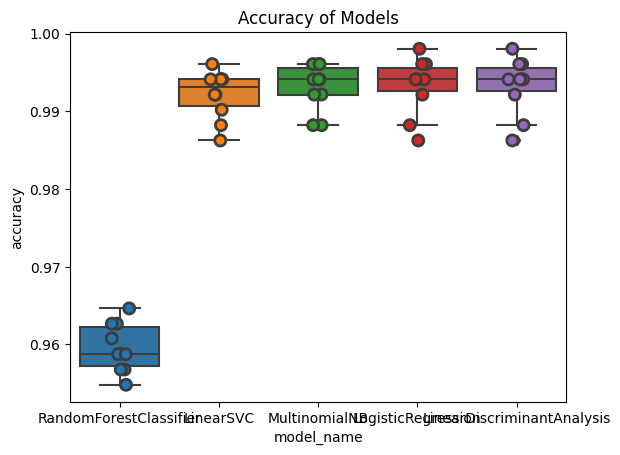

<Figure size 640x480 with 0 Axes>

In [47]:
cv_df = compare_models(X, y, 'Accuracy of Models')

In [49]:
def sample_estimator_sizes(estimator_sizes, X, y):
    estimator_results = []
    for n_estimators in estimator_sizes:
        training_features, test_features, training_target, test_target = train_test_split(X,y,test_size=0.3,random_state=0)
        x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,test_size = 0.3,random_state=12)
        rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=0,
            verbose=0,
            class_weight='balanced')
        rf_model = rf_model.fit(X=x_train, y=y_train)
        y_pred = rf_model.predict(x_val)
        accuracy = metrics.accuracy_score(y_val, y_pred)
        precision = metrics.precision_score(y_val, y_pred)
        recall = metrics.recall_score(y_val, y_pred)
        # print('number of estimators: ', n_estimators)
        # print('precision: {}'.format(precision), 'recall: {}'.format(recall), 'accuracy: {}'.format(accuracy))

        kfold = KFold(n_splits=10, shuffle=True, random_state=1)
        results = cross_val_score(rf_model, x_train, y_train,scoring='accuracy', cv=kfold)
        # print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

        results_dict = {'estimator': n_estimators, 'kfold_accuracy': results.mean(), 'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1': metrics.f1_score(y_val, y_pred)}
        estimator_results.append(pd.DataFrame([results_dict]))
    estimator_results_df = pd.concat(estimator_results)
    return estimator_results_df

In [50]:
estimator_results_df = sample_estimator_sizes([10, 50, 100, 200, 300, 400, 500], X, y)

In [51]:
estimator_results_df

,estimator,kfold_accuracy,precision,recall,accuracy,f1
0,10,0.995679,0.989362,0.948980,0.997251,0.968750
0,50,0.996268,1.000000,0.959184,0.998168,0.979167
0,100,0.996464,1.000000,0.959184,0.998168,0.979167
0,200,0.996464,1.000000,0.959184,0.998168,0.979167
0,300,0.996464,1.000000,0.959184,0.998168,0.979167
0,400,0.996464,1.000000,0.959184,0.998168,0.979167
0,500,0.996464,1.000000,0.959184,0.998168,0.979167


In [38]:
subset_predictions_df

,cleaned_magazine_title,ht_generated_title,htid,hdl_link,cleaned_volume,start_issue,end_issue,datetime,dates,issue_number,...,predicted_issue_number,max_issue_length,token_length,tokenized_text,tokenized_text_length,sentences,sentences_length,issue_size,issue_counts,class_numb
0,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,5439,"[!, €, ‘, §4, *, ', 7¢\, ``, ``, '', ``, '', ....",3229,"[!€‘§4*'7¢\ "" """" """".‘_' """"_""‘ """"__,/ """"‘..'~-....",201,42,45123,0
1,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,54,"[AT, ILLINOIS, LIBRARY, OF, THE, UNIVERSITY, U...",7,[AT ILLINOIS LIBRARY OF THE UNIVERSITY URBANA-...,1,42,45123,0
2,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,404,"[#, ', ``, ,, -, --, -LRB-, -RRB-, ., ..., 0CT...",76,"[# ' '' , - -- -LRB- -RRB- ., ... 0CT 1 11 198...",4,42,45123,0
3,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,2,[~L],1,[~L],1,42,45123,0
4,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,28,"[', ._.____, 1, _, fﬂﬁ, ~, », —-—, », -——]",10,[' ._.____ 1 _ fﬂﬁ ~ »—-—»-——],1,42,45123,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,8,"[!, (, 4, I, s]",5,"[!, (4 I s]",2,45,50222,0
1968,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,3,"[I, i]",2,[I i],1,45,50222,0
1969,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,2,[ii],1,[ii],1,45,50222,0
1970,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,1486,"[!, ``, ``, _, ``, __, ``, ’, ________, “, ', ...",663,"[! "", ""_ ""__ ""’________“ ' '4'_ '5 '_,_ '__ '_...",10,45,50222,0


In [37]:
input_value = combined_df.start_issue.unique().tolist()[0]
most_likely_predicted_issue = combined_df.iloc[(combined_df['predicted_issue_number']-input_value).abs().argsort()[:1]]
top_predictions = predictions[(predictions.max_issue_length == most_likely_predicted_issue.max_issue_length.values[0])]
finalized_issue_length = top_predictions.max_issue_length.unique().tolist()[0]

NameError: name 'predictions' is not defined

In [53]:
def get_finalized_dataset(df, max_issue_length):
    subset_digits = clean_digits(df)
    tqdm.pandas()
    htids = subset_digits.htid.unique().tolist()
    dfs = []
    for htid in tqdm(htids, total=len(htids), desc='Processing digits'):
            subset_df = subset_digits[subset_digits.htid == htid]
            subset_df = get_predicted_page(subset_df, [max_issue_length])
            dfs.append(subset_df)
    combined_subset_digits = pd.concat(dfs)
    combined_subset_digits = combined_subset_digits.reset_index(drop=True)
    digit_cols = combined_subset_digits.columns.tolist()
    digit_cols = [x for x in digit_cols if x not in ['pos', 'count', 'section', 'token']]
    combined_subset_digits = combined_subset_digits[digit_cols]
    cols = list(set(df) & (set(combined_subset_digits)))

    merged_df = pd.merge(df, combined_subset_digits, on=cols, how='left')
    if merged_df['volume_number'].isna().all():
            merged_df = merged_df.drop(columns='volume_number')
    pages_cols = merged_df.columns.tolist()
    holdout_cols = ['section', 'token', 'pos', 'count', 'number', 'implied_zero']
    pages_cols = [x for x in pages_cols if x not in holdout_cols]
    pages_df = merged_df[pages_cols]
    pages_df = pages_df.drop_duplicates()
    groupby_cols = ['cleaned_magazine_title', 'ht_generated_title', 'volume_number', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence'] if 'volume_number' in merged_df.columns else ['cleaned_magazine_title', 'ht_generated_title', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence']
    final_df = merged_df.groupby(groupby_cols, as_index = False).agg({'token': ' '.join, 'count': list, 'number': list, 'implied_zero': list})
    final_cols = list(set(pages_df) & set(final_df))
    finalized_df = pd.merge(pages_df, final_df, on=final_cols, how='left')
    return finalized_df

In [99]:
finalized_df = get_finalized_dataset(initial_df, finalized_issue_length)

Processing digits: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


In [100]:
len(initial_df), len(finalized_df)

(363936, 1941)

In [63]:
# Issue size compared to issue tokens
alt.Chart(issues_df).mark_circle().encode(
    x='issue_counts:Q',
    y='issue_size:Q',
    color=alt.Color('year(datetime):O', scale=alt.Scale(scheme='category20b')),
    # color=alt.Color('magazine_title:O', scale=alt.Scale(scheme='category10')),
).properties(
    width=100,
    height=100
).facet(
    facet='cleaned_magazine_title:O',
    # facet='year(datetime):T',
    columns=3
).resolve_scale(x='independent', y='independent')

alt.FacetChart(...)

In [64]:
len(finalized_df[finalized_df.type_of_page == 'content']), len(finalized_df[finalized_df.type_of_page == 'cover_page']), len(finalized_df[finalized_df.type_of_page == 'toc']), len(finalized_df[finalized_df.predicted_page.notna()])

(1864, 40, 35, 77)

In [68]:
len(finalized_df[finalized_df.type_of_page == 'content'].sample(frac=0.04))

75

In [69]:
content_docs = finalized_df[finalized_df.type_of_page == 'content'].sample(frac=0.04)
cover_docs = finalized_df[finalized_df.type_of_page == 'cover_page']
toc_docs = finalized_df[finalized_df.type_of_page == 'toc']
predicted_docs = finalized_df[finalized_df.predicted_page.notna()]

docs = pd.concat([content_docs, cover_docs, toc_docs, predicted_docs])

In [70]:
remainder_docs = finalized_df[~finalized_df.index.isin(docs.index)]

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer